In [1]:
import mne
import os
import re


In [20]:
# create mri dirs in all subs

subs_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
subs_dir = os.listdir(subs_path)

for sub_dir in subs_dir:
    if 'sub' in sub_dir:
        path = os.path.join(subs_path, sub_dir, 'mri')
        os.mkdir(path)


In [ ]:
# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'

for subject in os.listdir(subjects_dir):
    subject_dir = os.path.join(subjects_dir, subject)
    mri_dir = os.path.join(subject_dir, 'mri')
    epochs_dir = os.path.join(subject_dir, 'epochs')
    epochs_file = os.listdir(epochs_dir)[0]


In [ ]:
# dirs to test SR on single subject
subject_dir = os.path.join(subjects_dir, 'sub2')
mri_dir = os.path.join(subject_dir, 'mri')
epochs_dir = os.path.join(subject_dir, 'epochs')
epochs_file = os.listdir(epochs_dir)[0]

print(subject_dir, mri_dir, epochs_dir, epochs_file, sep='\n')


In [27]:
 #! CHANGED
subjects_mri_dir = 'D:\\Ekaterina_Voevodina\\MRI_FS\\'
subject = 'Sub2_memform'

In [23]:
 #! CHANGED
for subject in os.listdir(subjects_mri_dir):
    subject_id = int(re.search(r'\d+', subject).group()) #?
    print(subject, f'sub{subject_id}')

Sub2_memform sub2
Sub3__memform sub3
Sub4_memform sub4
Sub6_memform sub6
Sub8_memform sub8
Sub9_memform sub9
Subject10_memform sub10
Subject11_memform sub11
Subject12_memform sub12
Subject15_memform sub15
Subject17_memform sub17
Subject19_memform sub19
Subject20_memform sub20
Subject22_memform sub22
Subject23_memform sub23
Subject24_memform sub24
Subject25_memform sub25
Subject26_memform sub26
Subject7_memform sub7


In [28]:
 #! CHANGED
subject_mri_dir = os.path.join(subjects_mri_dir, 'Sub2_memform')

In [29]:
 #! CHANGED
trans_path = os.path.join(subject_mri_dir,'sub2_trans')
trans = mne.read_trans(trans_path)

In [30]:
subject_id = int(re.search(r'\d+', subject).group())
subject_id

2

In [31]:
subject_id = int(re.search(r'\d+', subject).group())
root = '../'
subject_meg_dir = os.path.join(
    root, 'data', 'subjects', f'sub{subject_id}'
)
subject_epochs_dir = os.path.join(subject_meg_dir, 'epochs')
subject_epochs_path = os.path.join(subject_epochs_dir, os.listdir(subject_epochs_dir)[0])

epochs = mne.read_epochs(subject_epochs_path)
info = epochs.info

Reading d:\Ekaterina_Voevodina\memory_formation\dirty_field\..\data\subjects\sub2\epochs\enc_epochs.fif ...


C:\Users\CCDM\AppData\Local\Temp\ipykernel_12916\3138727117.py:9: RuntimeWarning: This filename (../data\subjects\sub2\epochs\enc_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(subject_epochs_path)


    Found the data of interest:
        t =   -1500.00 ...    3995.00 ms
        0 CTF compensation matrices available
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated


In [32]:
src = mne.setup_source_space(
    subject, spacing='oct6', add_dist='patch',
    subjects_dir=subjects_mri_dir)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\Ekaterina_Voevodina\MRI_FS
Subject      = Sub2_memform
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\surf\lh.white...
Mapping lh Sub2_memform -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/158411 selected to source space (oct = 6)

Loading D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\surf\rh.white...
Mapping rh Sub2_memform -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/151372 selected to source space (oct = 6)

Calculating patch inform

In [33]:
conductivity = (0.3,)  # for single layer

model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_mri_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.87 -19.58  35.45 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


In [34]:
mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                       meg=['helmet', 'sensors'], subjects_dir=subjects_mri_dir,
                       surfaces='head-dense')

Using pyvistaqt 3d backend.

Using lh.seghead for head surface.
Getting helmet for system 306m
Channel types::	grad: 204, mag: 102


Using surface: D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\bem\inner_skull.surf
Using surface: D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\bem\outer_skull.surf
Using surface: D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\bem\outer_skin.surf


d:\Ekaterina_Voevodina\memory_formation\venv\lib\site-packages\mne\viz\utils.py:124: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


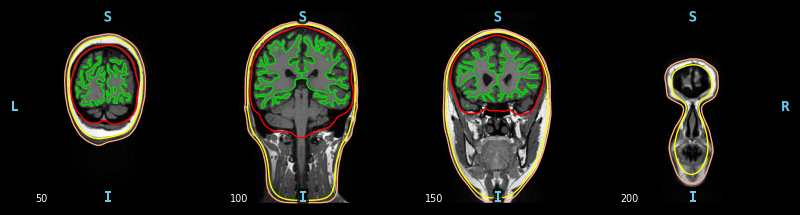

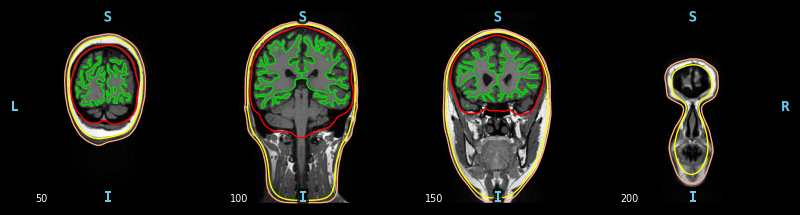

In [35]:
plot_bem_kwargs = dict(
    subject=subject, subjects_dir=subjects_mri_dir,
    brain_surfaces='white', orientation='coronal',
    slices=[50, 100, 150, 200])
mne.viz.plot_bem(**plot_bem_kwargs)

Using surface: D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\bem\inner_skull.surf
Using surface: D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\bem\outer_skull.surf
Using surface: D:\Ekaterina_Voevodina\MRI_FS\Sub2_memform\bem\outer_skin.surf


d:\Ekaterina_Voevodina\memory_formation\venv\lib\site-packages\mne\viz\utils.py:124: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


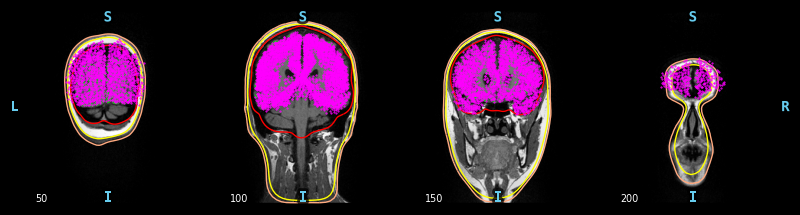

In [36]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

In [37]:
fig = mne.viz.plot_alignment(subject=subject, subjects_dir=subjects_mri_dir,
                             surfaces='white', coord_frame='mri',
                             src=src)
mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
                    distance=0.30, focalpoint=(-0.03, -0.01, 0.03))

In [38]:
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=158411, n_used=4098>, <surface (rh), n_vertices=151372, n_used=4098>] MRI (surface RAS) coords, subject 'Sub2_memform', ~28.4 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999479 -0.032275 -0.000017       1.68 mm
     0.031390  0.971958  0.233051      19.46 mm
    -0.007505 -0.232930  0.972465      18.91 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000      45.00 mm
     0.000000  0.000000  0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2883 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1979.8 ms
    4 source space point omitted because of the    5.0-mm distance limit.
    Computing patch statistics...
    Patch information added...
Checking surface interior status for 4098 points...
    Found 1286/4098 points inside  an interior sphere of radius   46.8 mm
    Found    0/4098 points outside an exterior sphere of radius   92.5 mm
    Found    0/2812 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2812 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 1924.7 ms

Checking surface interior status for 306 points...
    Found   0/306 points inside  an interior sphere of radius   46.8 mm
    Found 306/306 points outside an exterior sphere of radius   92.5 mm
    Found   0/  0 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found   0/  0 points outside using solid angles
    Total 0/306 points inside the surface
Interior check completed in 223.2 ms
Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing MEG at 8192 source locations (free orientations)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished



Finished.


In [14]:
fwd

Good channels,"204 Gradiometers, 102 Magnetometers"
Bad channels,None
Source space,Surface with 8192 vertices
Source orientation,Free


In [36]:
print(f'Before: {src}')
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=158411, n_used=4098>, <surface (rh), n_vertices=151372, n_used=4098>] MRI (surface RAS) coords, subject 'Sub2_memform', ~28.4 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=158411, n_used=4094>, <surface (rh), n_vertices=151372, n_used=4098>] head coords, subject 'Sub2_memform', ~28.4 MB>


In [39]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 306 sensors x 24576 dipoles


In [40]:
data_cov = mne.compute_covariance(epochs, tmin=-.5, tmax=1.5,
                                  method='empirical')

Computing rank from data with rank=None
    Using tolerance 2.8e-08 (2.2e-16 eps * 306 dim * 4.2e+05  max singular value)
    Estimated rank (mag + grad): 306
Found multiple SSS records. Using the first.
    MEG: rank 306 computed from 306 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_12916\1882247938.py:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov = mne.compute_covariance(epochs, tmin=-.5, tmax=1.5,


Reducing data rank from 306 -> 306
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 84210
[done]


In [41]:
#! CHANGED
empty_room_file =  mne.io.read_raw_fif('D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects\\empty_room_tsss.fif', preload=True)
empty_room_file = empty_room_file.resample(200)


empty_room_filt = empty_room_file.copy()\
    .filter(l_freq=.5, h_freq=90)\
    .notch_filter(50) # filter data

noise_cov = mne.compute_raw_covariance(
    empty_room_filt, tmin=0, tmax=None)

Opening raw data file D:\Ekaterina_Voevodina\memory_formation\data\subjects\empty_room_tsss.fif...
Isotrak not found
    Range : 45000 ... 329999 =     45.000 ...   329.999 secs
Ready.
Reading 0 ... 284999  =      0.000 ...   284.999 secs...


C:\Users\CCDM\AppData\Local\Temp\ipykernel_12916\1468201446.py:1: RuntimeWarning: This filename (D:\Ekaterina_Voevodina\memory_formation\data\subjects\empty_room_tsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  empty_room_file =  mne.io.read_raw_fif('D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects\\empty_room_tsss.fif', preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using up to 1425 segments


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.2s finished


Number of samples used : 57000
[done]


In [13]:
epochs.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 2 EOG, 1 ECG, 13 misc, 4 Stimulus, 9 CHPI
 custom_ref_applied: False
 description: Vectorview system
 dev_head_t: MEG device -> head transform
 dig: 203 items (3 Cardinal, 4 HPI, 196 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 90.0 Hz
 meas_date: 2021-04-21 13:01:38 UTC
 meas_id: 4 items (dict)
 nchan: 335
 proc_history: 2 items (list)
 proj_id: 1 item (ndarray)
 proj_name: memory_formation
 projs: []
 sfreq: 200.0 Hz
 subject_info: 6 items (dict)
>

In [78]:
empty_room_filt.info

<Info | 18 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 2 EOG, 1 ECG, 13 misc, 4 Stimulus
 custom_ref_applied: False
 description: Vectorview system
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 90.0 Hz
 meas_date: 2021-04-07 06:29:37 UTC
 meas_id: 4 items (dict)
 nchan: 326
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: meditation
 projs: []
 sfreq: 200.0 Hz
 subject_info: 6 items (dict)
>

Computing rank from covariance with rank=None
    Using tolerance 4.5e-14 (2.2e-16 eps * 102 dim * 2  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 5.4e-13 (2.2e-16 eps * 204 dim * 12  max singular value)
    Estimated rank (grad): 80
Found multiple SSS records. Using the first.
    GRAD: rank 80 computed from 204 data channels with 0 projectors


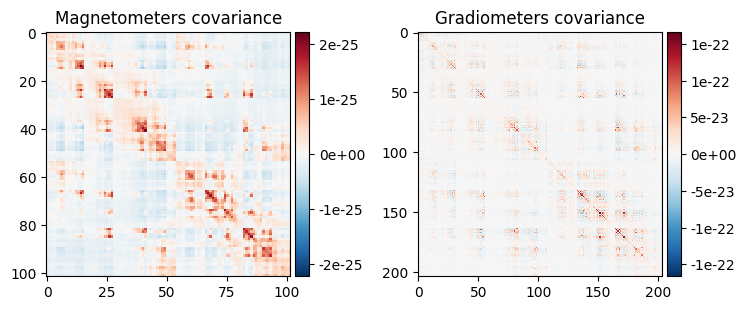

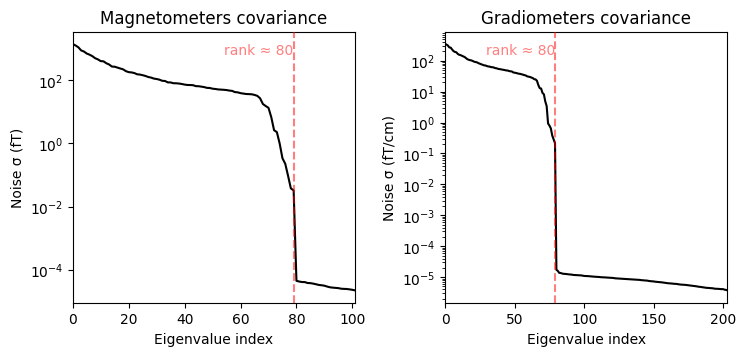

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [43]:
data_cov.plot(epochs.info)

Computing rank from covariance with rank=None
    Using tolerance 1.7e-15 (2.2e-16 eps * 102 dim * 0.075  max singular value)
    Estimated rank (mag): 68
    MAG: rank 68 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.9e-14 (2.2e-16 eps * 204 dim * 0.63  max singular value)
    Estimated rank (grad): 68
    GRAD: rank 68 computed from 204 data channels with 0 projectors


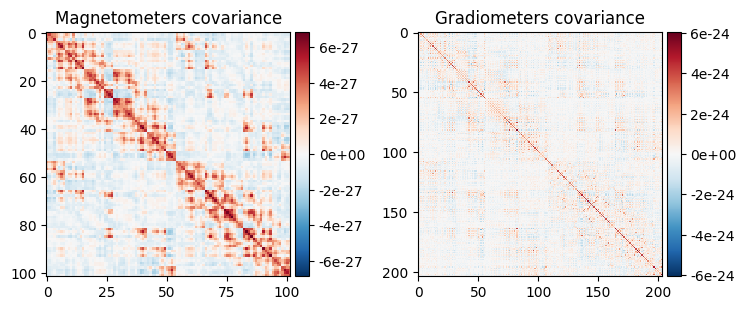

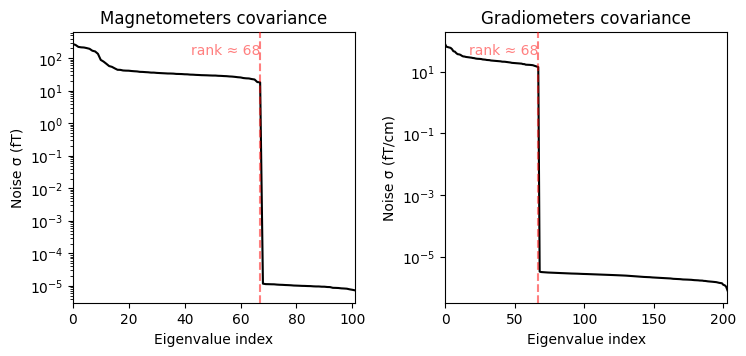

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [44]:
noise_cov.plot(empty_room_filt.info)

In [71]:
import scipy.io as spio
import numpy as np
nc2str = spio.loadmat("Z:\\DATA\\MOSCOW\\MEG\\empty_room\\noisecov306.mat")
np.shape(nc2str)
nc2str.items()
noisecov306 = nc2str['noisecov306']
np.shape(noisecov306)


(306, 306)

In [73]:
noise_cov2 = noise_cov
noise_cov2['data'] = noisecov306

In [46]:
# filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
#                     noise_cov=noise_cov, pick_ori='max-power',
#                     weight_norm='unit-noise-gain', rank=None)

filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info', reduce_rank=True)

# filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
#                     noise_cov=noise_cov, pick_ori='max-power',
#                     weight_norm='unit-noise-gain', rank='full')

# reg=0.05 loading the diagonal of the covariance matrix with 5% of the sensor power

Computing rank from covariance with rank='info'
    MEG: rank 306 after 0 projectors applied to 306 channels
Computing rank from covariance with rank='info'
    MEG: rank 306 after 0 projectors applied to 306 channels
Making LCMV beamformer with rank {'meg': 306}
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Whitening the forward solution.
Computing rank from covariance with rank={'meg': 306}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.


C:\Users\CCDM\AppData\Local\Temp\ipykernel_12916\855342051.py:5: RuntimeWarning: The passed rank['meg']=306 exceeds the estimated rank of the noise covariance (68) leading to a potential increase in noise during whitening by a factor of 4e+07. Ensure that the rank correctly corresponds to that of the given noise covariance matrix.
  filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,


Computing beamformer filters for 8192 sources
Filter computation complete


In [101]:
import numpy as np
np.shape(filters['weights'])



(8192, 306)

In [ ]:
stc = mne.beamformer.apply_lcmv_epochs(epochs.filter(4., 8.), filters)
# stc = mne.beamformer.apply_lcmv(epochs.average(), filters)

In [49]:
stc = mne.beamformer.apply_lcmv(epochs.filter(4., 8.).average(), filters)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 64260 out of 64260 | elapsed:   12.0s finished


In [19]:
stc_hits = mne.beamformer.apply_lcmv(epochs['hits'].filter(4., 8.).average(), filters) # dipoles x time for condition 1
stc_miss = mne.beamformer.apply_lcmv(epochs['miss'].filter(4., 8.).average(), filters) # dipoles x time for condition 2

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 39780 out of 39780 | elapsed:    7.2s finished


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 331 samples (1.655 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 24480 out of 24480 | elapsed:    4.4s finished


In [16]:
len(stc)


210

In [50]:
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=subjects_mri_dir,
              initial_time=None, verbose=True)

In [110]:
np.min(stc[0].data)

-2421778.4595724056

In [22]:
import numpy as np

stc_data = np.array([
    stc_.data
    for stc_ in stc
])

In [71]:
stc_data.shape

(210, 8192, 1100)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(stc_data.mean(0).T)

* band pass filter for theta, alpha, beta, and gamma -> single epoch
* compute lcmv
* epochs in source space
* envelope on single epoch
* average envelopes

In [56]:
stc

<SourceEstimate | 8192 vertices, subject : Sub2_memform, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>

In [1]:
%matplotlib qt
fig = stc.plot(hemi='both', clim=dict(kind='value', pos_lims=lims), **kwargs)

NameError: name 'stc' is not defined

In [83]:
type(fig)

mne.viz._brain._brain.Brain

In [26]:
surfer_kwargs = dict(
    hemi='lh', subjects_dir=subjects_mri_dir,
    clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
    initial_time=0.09, time_unit='s', size=(800, 800),
    smoothing_steps=5)
stc.plot(**surfer_kwargs)

AttributeError: 'list' object has no attribute 'plot'

In [53]:
kwargs = dict(src=src, subject=subject, subjects_dir=subjects_mri_dir,
              initial_time=0.087, verbose=True)
stc.plot(hemi='lh', clim=dict(kind='value', lims=lims), **kwargs)

OverflowError: argument 1 overflowed: value must be in the range -2147483648 to 2147483647